This notebook shows how to use hybrid kernel, which is tensorproduct of marginalized graph kernel (MGK) and radial basis function (RBF) kernel.

For MGK, the input is molecular graph.

For RBF kernel, the input is temperature.

This is an example for surface tension.

In [1]:
import pandas as pd
df = pd.read_csv('../datasets/slab-sim.csv')
from mgktools.data.data import Dataset
dataset = Dataset.from_df(
    df,
    pure_columns = ['smiles'],
    feature_columns = ['redT'],
    target_columns = ['st'],
    group_reading = True,
    n_jobs = 1
)
# Save the dataset as dataset.pkl.
import os
if not os.path.exists('st'):
    os.mkdir('st')
dataset.save(path='st', filename='dataset.pkl', overwrite=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 633 out of 633 | elapsed:    5.8s finished


In [2]:
from mgktools.kernels.utils import get_kernel_config
from mgktools.hyperparameters import product_msnorm
dataset.graph_kernel_type = 'graph'
dataset.set_ignore_features_add(True)
kernel_config = get_kernel_config(
    dataset,
    graph_kernel_type = 'graph',
    # arguments for marginalized graph kernel
    mgk_hyperparameters_files = [product_msnorm],
)
kernel = kernel_config.kernel

In [3]:
kernel_dict = kernel_config.get_kernel_dict(dataset.X, dataset.X_repr.ravel())
import os, pickle
kernel_pkl = os.path.join('st', 'kernel.pkl')
pickle.dump(kernel_dict, open(kernel_pkl, 'wb'), protocol=4)

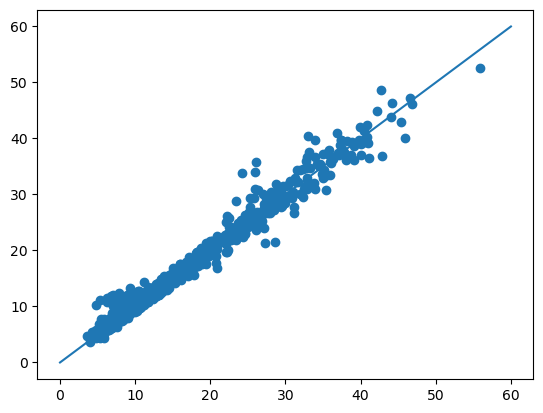

In [4]:
dataset.set_ignore_features_add(False)
kernel_config = get_kernel_config(
    dataset,
    graph_kernel_type = 'pre-computed',
    # arguments for pre-computed kernel
    kernel_pkl = 'st/kernel.pkl',
    features_kernel_type = 'rbf',
    features_hyperparameters = [0.1],
)
kernel = kernel_config.kernel

dataset.graph_kernel_type = 'pre-computed'
from mgktools.data import dataset_split
train, test = dataset_split(dataset, 
                            split_type='random',
                            sizes=[0.8, 0.2])
from mgktools.models.regression.GPRgraphdot.gpr import GPR
gpr = GPR(kernel=kernel,
          optimizer=None,
          alpha=0.01,
          normalize_y=True)
gpr.fit(train.X, train.y)
y_pred = gpr.predict(test.X)
import matplotlib.pyplot as plt
plt.scatter(test.y, y_pred)
plt.plot([0, 60], [0, 60])